# Shared-boundary-weighted `W`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from libpysal.weights import Rook, Queen, lag_spatial
from splot.libpysal import plot_spatial_weights

In [3]:
import matplotlib.pyplot as plt

In [4]:
import geopandas as gpd
from libpysal import examples

In [5]:
import libpysal
libpysal.__version__

'4.7.0+40.gc795feab541d.dirty'

Classic contiguity-based spatial weights are typically binary; if two units share an edge (for rook weights) or a edge/vertex (for queen weights), then they are taken as neighbors with an assigned weight value of 1. Then, it is common to row-standardize the weights so that the sum of weight values for unit i equals 1

This approach treats every neighbor equally, which in the case of regular or lattice data, makes perfect sense. Each side in a lattice has the same length, so all neighbors should be treated equally. In irregular data, like states, counties, or tracts, however, the borders between units are variable in length, so it makes sense to relax the assumption of neighbor equality.

For contiguity weights, one way to accomplish that is by setting the weight value equal to the lengh of the shared boundary between adjacent units. For example, California shares a much larger border with Nevada than it does with Arizona, so it might make sense to increase Nevada's "neighborliness" relative to Arizona.

But the question of standardization now includes an additional consideration. If we row-standardize the weights, following tradition, then the weights are effectively the proportion of the unit's shared boundary with its neighbors--or are they? What about states on the border?

Again, consider the case of California... Some of California touches Mexico and much of it touches the Pacific Ocean. Should the weights be standardized by state's entire border, or just the portion that touches other states?

In [6]:
from libpysal.weights import build_lattice_shapefile

In [7]:
build_lattice_shapefile(3, 3, "tmp.shp")
lattice = gpd.read_file("tmp.shp")

/Users/knaaptime/Dropbox/projects/libpysal/libpysal/cg/shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/knaaptime/Dropbox/projects/libpysal/libpysal/cg/shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/knaaptime/Dropbox/projects/libpysal/libpysal/cg/shapes.py:1923: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


<AxesSubplot: >

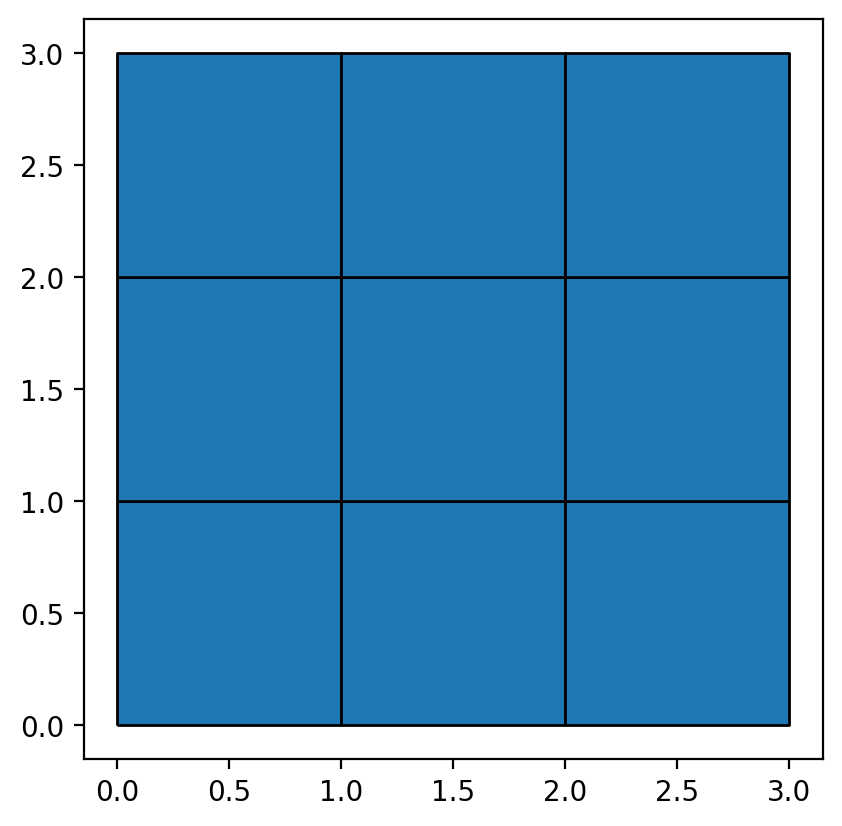

In [8]:
lattice.plot(edgecolor='black')

In [9]:

# traditional contiguity weights
w_lattice_rook = Rook.from_dataframe(lattice)

# shared-boundary weights
w_lattice_perim = Rook.from_dataframe(lattice, perimeter=True)

# # shared-boundary weights, normalized by the total *shared border* of each observation
w_lattice_perim_std = Rook.from_dataframe(lattice, perimeter=True, perim_std=True)

/var/folders/79/cknfb1sx2pv16rztkpg6wzlw0000gn/T/ipykernel_59576/2966444851.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_lattice_rook = Rook.from_dataframe(lattice)
/var/folders/79/cknfb1sx2pv16rztkpg6wzlw0000gn/T/ipykernel_59576/2966444851.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_lattice_perim = Rook.from_dataframe(lattice, perimeter=True)
/var/folders/79/cknfb1sx2pv16rztkpg6wzlw0000gn/T/ipykernel_59576/2966444851.py:8: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_lattice_perim_std = Rook.from_dataframe(lattice, perimeter=True, perim_std=True)


(<Figure size 600x600 with 1 Axes>, <AxesSubplot: >)

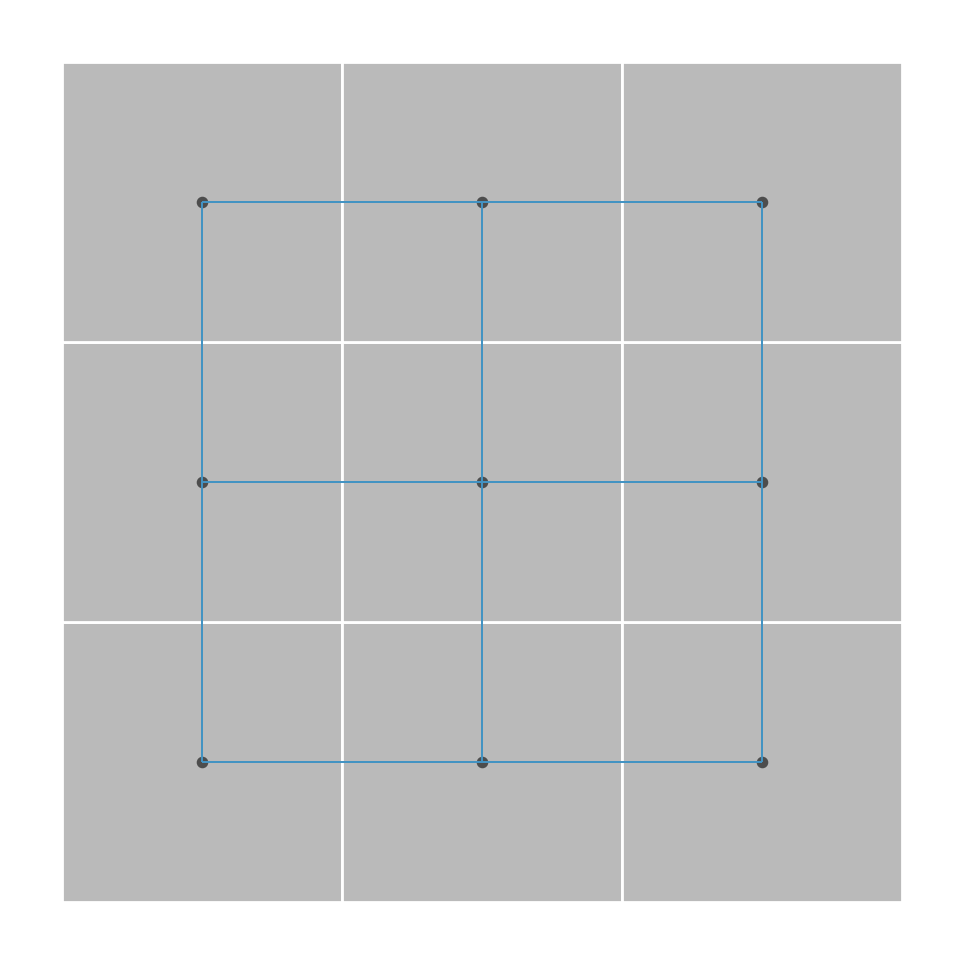

In [10]:
plot_spatial_weights(w_lattice_rook, lattice, figsize=(6,6))

In [11]:
# create a dummy variable of 1s
lattice['dummy'] = 1

In [12]:
# the spatial lag of the dummy variable gives the value of the summed weights

lattice['lag'] = lag_spatial(w_lattice_rook, lattice['dummy'])

for un-transformed weights, the lag is the sum of neighbor values

In [13]:
lattice

,ID,geometry,dummy,lag
0,0,"POLYGON ((0.00000 0.00000, 0.00000 1.00000, 1....",1,2.0
1,1,"POLYGON ((0.00000 1.00000, 0.00000 2.00000, 1....",1,3.0
2,2,"POLYGON ((0.00000 2.00000, 0.00000 3.00000, 1....",1,2.0
3,3,"POLYGON ((1.00000 0.00000, 1.00000 1.00000, 2....",1,3.0
4,4,"POLYGON ((1.00000 1.00000, 1.00000 2.00000, 2....",1,4.0
5,5,"POLYGON ((1.00000 2.00000, 1.00000 3.00000, 2....",1,3.0
6,6,"POLYGON ((2.00000 0.00000, 2.00000 1.00000, 3....",1,2.0
7,7,"POLYGON ((2.00000 1.00000, 2.00000 2.00000, 3....",1,3.0
8,8,"POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3....",1,2.0


observation 4 (in the center) shares a boundary of length 1 with four other cells (its rook neighbors, obviously) for a total weights value of 4

In [14]:
w_lattice_rook.transform = 'r'

In [15]:
lattice['lag_row_std'] = lag_spatial(w_lattice_rook, lattice['dummy'])

with row-standardized we take the weighted average (rather than the weighted sum) of neighboring values, so our summed weights for each observation is 1 (theres a border of length==1 for each neighbor)

In [16]:
lattice

,ID,geometry,dummy,lag,lag_row_std
0,0,"POLYGON ((0.00000 0.00000, 0.00000 1.00000, 1....",1,2.0,1.0
1,1,"POLYGON ((0.00000 1.00000, 0.00000 2.00000, 1....",1,3.0,1.0
2,2,"POLYGON ((0.00000 2.00000, 0.00000 3.00000, 1....",1,2.0,1.0
3,3,"POLYGON ((1.00000 0.00000, 1.00000 1.00000, 2....",1,3.0,1.0
4,4,"POLYGON ((1.00000 1.00000, 1.00000 2.00000, 2....",1,4.0,1.0
5,5,"POLYGON ((1.00000 2.00000, 1.00000 3.00000, 2....",1,3.0,1.0
6,6,"POLYGON ((2.00000 0.00000, 2.00000 1.00000, 3....",1,2.0,1.0
7,7,"POLYGON ((2.00000 1.00000, 2.00000 2.00000, 3....",1,3.0,1.0
8,8,"POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3....",1,2.0,1.0


In [17]:
lattice['lag_perim_std'] = lag_spatial(w_lattice_perim_std, lattice['dummy'])

In [18]:
lattice['lag_perim'] = lag_spatial(w_lattice_perim, lattice['dummy'])

In [19]:
# now row-standardize the perimeter weights
w_lattice_perim.transform = 'r'

In [20]:
# these weights have been rescaled so their total==1 but their relative importance is different than the simple rook case
lattice['lag_perim_rowstd'] = lag_spatial(w_lattice_perim, lattice['dummy'])

In [21]:
lattice

,ID,geometry,dummy,lag,lag_row_std,lag_perim_std,lag_perim,lag_perim_rowstd
0,0,"POLYGON ((0.00000 0.00000, 0.00000 1.00000, 1....",1,2.0,1.0,0.50,2.0,1.0
1,1,"POLYGON ((0.00000 1.00000, 0.00000 2.00000, 1....",1,3.0,1.0,0.75,3.0,1.0
2,2,"POLYGON ((0.00000 2.00000, 0.00000 3.00000, 1....",1,2.0,1.0,0.50,2.0,1.0
3,3,"POLYGON ((1.00000 0.00000, 1.00000 1.00000, 2....",1,3.0,1.0,0.75,3.0,1.0
4,4,"POLYGON ((1.00000 1.00000, 1.00000 2.00000, 2....",1,4.0,1.0,1.00,4.0,1.0
5,5,"POLYGON ((1.00000 2.00000, 1.00000 3.00000, 2....",1,3.0,1.0,0.75,3.0,1.0
6,6,"POLYGON ((2.00000 0.00000, 2.00000 1.00000, 3....",1,2.0,1.0,0.50,2.0,1.0
7,7,"POLYGON ((2.00000 1.00000, 2.00000 2.00000, 3....",1,3.0,1.0,0.75,3.0,1.0
8,8,"POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3....",1,2.0,1.0,0.50,2.0,1.0


In [22]:
lattice.lag_row_std == lattice.lag_perim_rowstd

0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
dtype: bool

any observation whose summed weights are less than one has a piece of its boundary that does not touch a neighbor. That is, any observation where `lag_perim_std` is less than one should lie on the border of the dataset. Alternatively, any observation whose summed weights equal 1 shares its *entire border* with other observations, thus it must lie somewhere on the interior of the dataset

<AxesSubplot: >

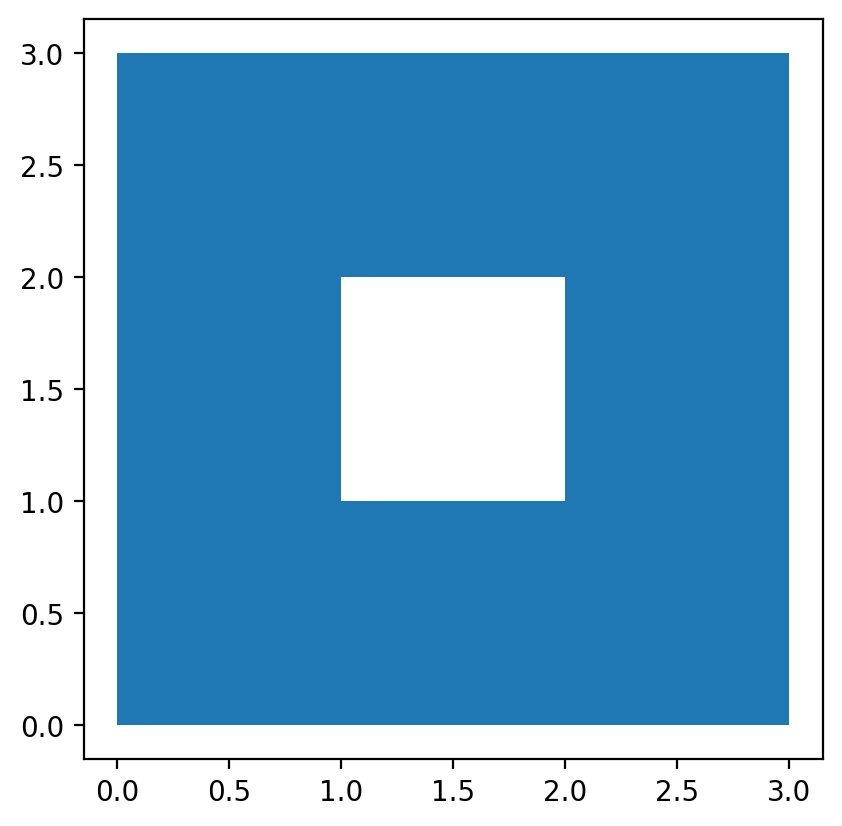

In [23]:
lattice[lattice.lag_perim_std<1].plot()

## U.S. Example

In [24]:
us = gpd.read_file(examples.get_path("us48.shp")).set_crs(4326).to_crs(5070)

In [25]:
w_us_rook = Rook.from_dataframe(us)
w_us_perim = Rook.from_dataframe(us.reset_index(), perimeter=True)
w_us_perim_std = Rook.from_dataframe(us.reset_index(), perimeter=True, perim_std=True)

/var/folders/79/cknfb1sx2pv16rztkpg6wzlw0000gn/T/ipykernel_59576/791916487.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_us_rook = Rook.from_dataframe(us)
/var/folders/79/cknfb1sx2pv16rztkpg6wzlw0000gn/T/ipykernel_59576/791916487.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_us_perim = Rook.from_dataframe(us.reset_index(), perimeter=True)
/var/folders/79/cknfb1sx2pv16rztkpg6wzlw0000gn/T/ipykernel_59576/791916487.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_us_perim_std = Rook.from_dataframe(us.reset_index(), perimeter=True, perim_std=True)


(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot: >)

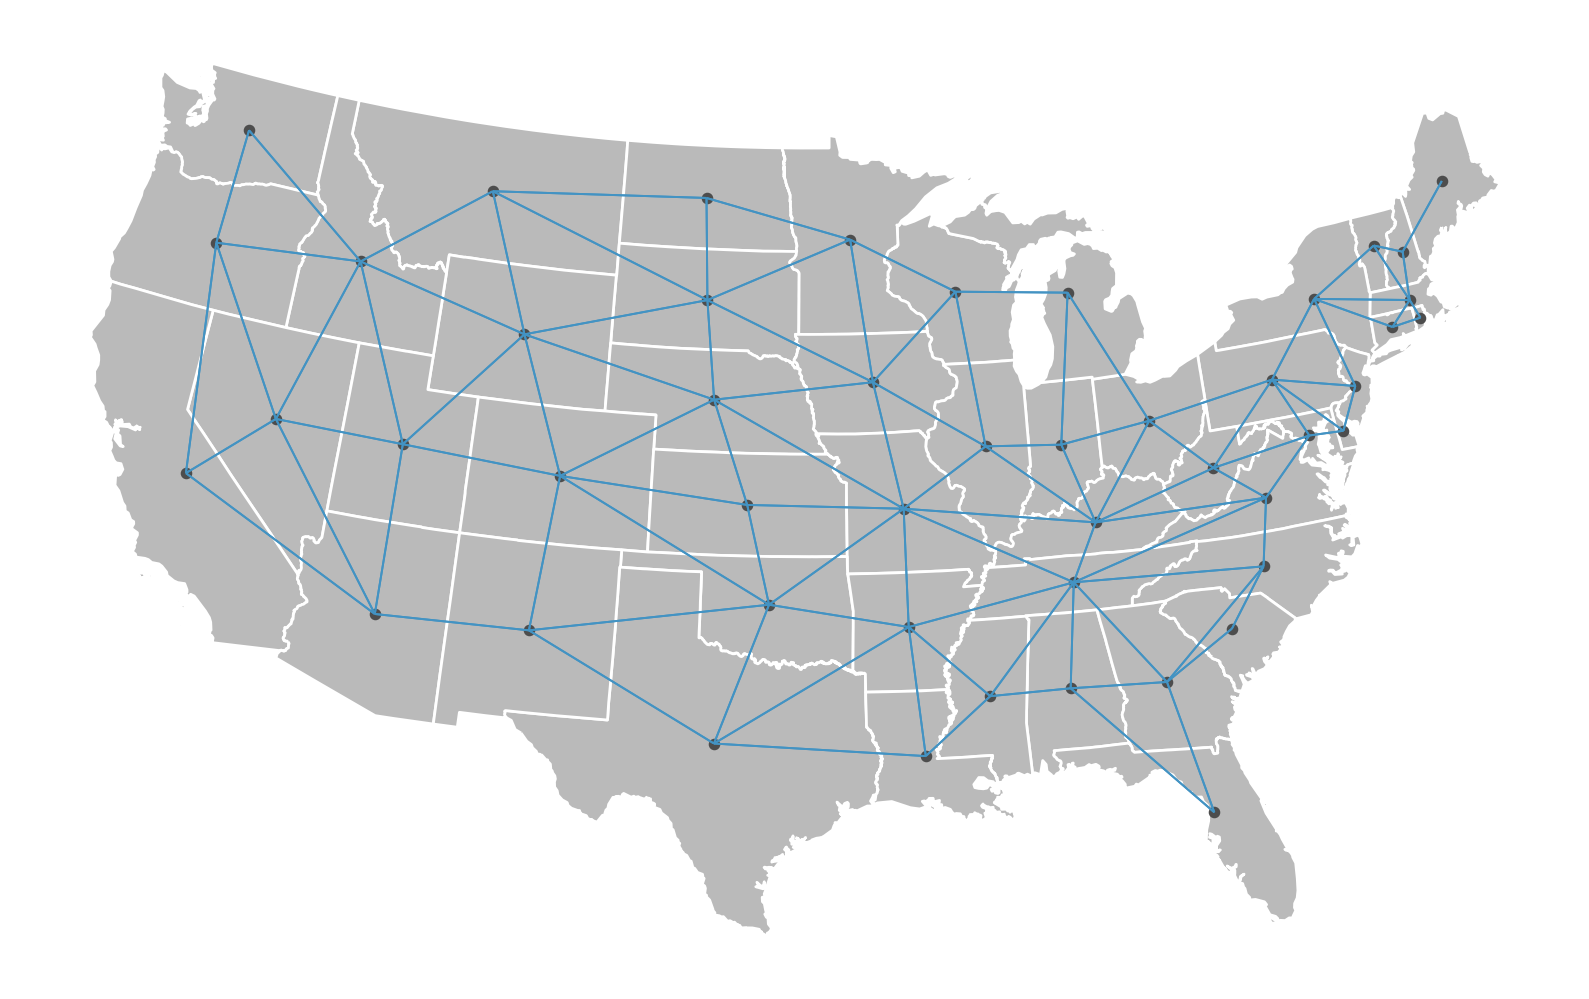

In [26]:
plot_spatial_weights(w_us_rook, us)

(wait, why are wisconsin and michigan rook neighbors? thanks to the UP, michigan is a multipolygon)

In [27]:
# these are california's neighbors

us.loc[w_us_rook.neighbors[23]]

,AREA,PERIMETER,STATE_,STATE_ID,STATE_NAME,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
34,28.859,23.257,36,36,Arizona,04,Mtn,AZ,"POLYGON ((-1708456.815 1273380.880, -1711763.0..."
10,28.187,24.787,11,11,Oregon,41,Pacific,OR,"POLYGON ((-2068143.002 2388778.610, -2134763.1..."
21,29.969,23.608,22,22,Nevada,32,Mtn,NV,"POLYGON ((-1982749.369 1951705.269, -1993571.7..."


With a classic rook W, each of california's neighbors get a weight of 1

In [28]:
w_us_rook.weights[23]

[1.0, 1.0, 1.0]

In [29]:
# with perimeter=True, the weight values are equal to the lengh of the shared border 
# (here in meters, given the CRS)
w_us_perim.weights[23]

[346621.3071378854, 987071.8076548338, 353461.1203236629]

In [30]:
# with perimeter=True and perim_std=True, the weights are equal to the proportion of CA's *total boundary* shared with each state 
w_us_perim_std.weights[23]

[0.08306747657595963, 0.23655084835434284, 0.08470663149775297]

CA shares 
- 8.3% of its border with AZ
- 23.7% of its border with NV
- 8.5% of its border with OR


In [31]:
us['dummy'] = 1

In [32]:
us['shared_border_pct'] = lag_spatial(w_us_perim_std, us['dummy']).round(2)

At least 1% of the boundary from these states does not touch another state

In [33]:
us[us['shared_border_pct'].round(2)<1].explore()